In [14]:
using DataFrames, CSV
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots, GRUtils
using Distributions
using Gurobi, JuMP

## Optimization Project - Dual-A-Ride Problem (DARP).

`Authors: Marco Antonioli, Victor Radermecker`

`Date: October, 15th, 2022.`

The goal of this project is to propose a resolution of the Dual-A-Ride Problem (DARP) for the MIT Shuttle. Suppose that we have n passengers spread accross the campus and willing to travel to their final destination. Suppose that each passenger can request a ride through an application. Each ride is constituted of two points: the pick-up location A and the drop-off location B. The goal of the DARP is to find the optimal route to satisfy the needs of all passengers at an optimal cost.

Let's propose a first implementation of an algorithm that can resolve the DARP. This implementation was proposed by Cordeau (2006).

- One paper in Good Notes
- One paper here: http://www.iro.umontreal.ca/~marcotte/PLU6000/PLU6000_H04/Cordeau1.pdf


**Data:**

- A directed Graph: G(A,V)
  - V: vertices= {1, P, D, 2n+1} where {0, 2n+1} are the vertices corresponding the to depot of the shuttle (same geographical location).
  - A: edges between the different vertices.


In [15]:
# Constants
N = 3 ; # number of passengers
K = 3 ;  # number of shuttles

In [17]:
# Data
data = Matrix(DataFrame(CSV.File("../SimulatedDataTest.csv")));

q = data[1:2*N+2, 4];
d = data[1:2*N+2, 5];
e = data[1:2*N+2, 7];
l = data[1:2*N+2, 8];

In [18]:
#compute costs/time as euclidian distance.
c = zeros(2 * N + 2, 2 * N + 2)
for i = 1:2*N+2
    for j = 1:2*N+2
        c[i, j] = norm(data[i, 2:3] - data[j, 2:3]) / 10
    end
end

t = c  #let's consider in this initial model that the travel cost and the time and equivalent. 

8×8 Matrix{Float64}:
 0.0       0.291247  0.150659  0.743121  …  0.693661  1.31528   0.0
 0.291247  0.0       0.326118  0.620831     0.488037  1.03742   0.291247
 0.150659  0.326118  0.0       0.869122     0.789801  1.28146   0.150659
 0.743121  0.620831  0.869122  0.0          0.238253  1.26881   0.743121
 0.668374  0.379722  0.697821  0.585946     0.353577  0.733003  0.668374
 0.693661  0.488037  0.789801  0.238253  …  0.0       1.03335   0.693661
 1.31528   1.03742   1.28146   1.26881      1.03335   0.0       1.31528
 0.0       0.291247  0.150659  0.743121     0.693661  1.31528   0.0

In [19]:
model = Model(Gurobi.Optimizer)

V = [1, 2, 3, 4, 5, 6, 7, 8]   # all vertices
P = [2, 3, 4]             # pick up vertices
D = [5, 6, 7]             # drop off vertices
PUD = [2, 3, 4, 5, 6, 7]     # all pick up and drop off vertices together (all vertices except depot)

T = [100, 100, 100]       # maximum duration of route k
L = 100                  # maximum time of a drive
Q = [3, 3, 3]             # capacity of each car

# Variables
@variable(model, x[1:2*N+2, 1:2*N+2, 1:K] >= 0, Bin)   # x[i, j, k] = 1 if we go from node i to node j with vehicle k.
@variable(model, w[1:2*N+2, 1:K] >= 0, Int)            # w[i,k] load of vehicle k when arriving upon leaving vertex i
@variable(model, r[1:N] >= 0)                     # r[i,k] travel time of passenger i (Note that passenger i is identified by) the vertex i+1

# @variable(model, u[1:2*N+2, 1:K] >= 0)                 # u[i,k] time as which the vertex i is served by vehicle k
@variable(model, u_depot[1:2, 1:K] >= 0)
@variable(model, u[1:2*N] >= 0)
# @variable(model, u[[1:K],1:2*N,[1:K]] >= 0) #------< MAKE THAT MORE ELEGANT WHEN I WILL HAVE INTERNET.


#############  Constraints  #############

# only one car can bring passenger {i, i+N} to its final destination.
@constraint(model, [i in P], sum(sum(x[i, j, k] for j in V) for k = 1:K) == 1)

# each vehicle starts at the depot
@constraint(model, [k = 1:K], sum(x[1, j, k] for j in V) == 1)

# each vehicle ends at the depot
@constraint(model, [k = 1:K], sum(x[i, 2*N+2, k] for i in V) == 1)

# each passenger is picked and droped by the same car
@constraint(model, [i in P, k = 1:K], sum(x[i, j, k] for j in V) - sum(x[i+N, j, k] for j in V) == 0)

# vehicle k follows the edges sequentially
@constraint(model, [i in PUD, k = 1:K], sum(x[j, i, k] for j in V) - sum(x[i, j, k] for j in V) == 0)

#### -------- CORRETIONS ######

# PREVIOUS the time served of vertex i
# @constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= (u[i, k] + d[i] + t[i, j]) * x[i, j, k])

# PREVIOUS updating the travel time of passenger i
# @constraint(model, [i in P, k = 1:K], r[i-1, k] == u[N+i, k] - (u[i, k] + d[i]))


# We will reduce the number of variables by having a vector u[i,k] into simply:
#   u[i] --> time at which vertex i is considered
#   r[i] --> ride time of passenger i 
@constraint(model, [j in PUD, k = 1:K], u[j-1] >= (u_depot[1,k] + d[1] + t[1, j]) * x[1, j, k])
@constraint(model, [j in PUD, i in PUD], u[j-1] >= (u[i-1] + d[i] + t[i, j]) * sum(x[i, j, :]))
@constraint(model, [i in PUD, k = 1:K], u_depot[2,k] >= (u[i-1] + d[i] + t[i, 2*N+2]) * x[i, 2*N+2, k])
@constraint(model, [i in P], r[i-1] == u[i+N-1] - (u[i-1] + d[i]))

### ---> we are missing some constraints here because we use PUD instead of V only!
# @constraint(model, [k = 1:K], u_depot[1,k] >= (u_depot[1,k] + d[1] + t[1, 1]) * x[1, 1, k])
# @constraint(model, [k = 1:K], u_depot[2,k] >= (u_depot[1,k] + d[1] + t[1, 2*N+2]) * x[1, 2*N+2, k])

# @constraint(model, [k=1:K], u_depot[1,k] >= (u_depot[1,k] + d[1] + t[1, 1]) * sum(x[1, 1, :]))
# @constraint(model, [k=1:K], u_depot[1,k] >= (u_depot[2,k] + d[2*N+2] + t[2*N+2, 1]) * sum(x[2*N+2, 1, :]))
# @constraint(model, [k=1:K], u_depot[2,k] >= (u_depot[1,k] + d[1] + t[1, 2*N+2]) * sum(x[1, 2*N+2, :]))
# @constraint(model, [k=1:K], u_depot[2,k] >= (u_depot[2,k] + d[2*N+2] + t[2*N+2, 2*N+2]) * sum(x[2*N+2, 2*N+2, :]))

# @constraint(model, [k = 1:K], u_depot[2,k] >= (u_depot[1] + d[1] + t[1, 2*N+2]) * x[1, 2*N+2, k])
# @constraint(model, [k = 1:K], u_depot[2,k] >= (u_depot[2] + d[2] + t[2, 2*N+2]) * x[2, 2*N+2, k])





# maximum driving time of vehicle k
@constraint(model, [k = 1:K], u_depot[2, k] - u_depot[1, k] <= T[k])

#### -------- CORRETIONS ######

# respecting travel window of passenger i
@constraint(model, [i in PUD], e[i] <= u[i-1])
@constraint(model, [i in PUD], u[i-1] <= l[i])

## Adding the same constraints for the depot nodes
@constraint(model, [k=1:K], e[1] <= u_depot[1,k])
@constraint(model, [k=1:K], u_depot[1,k] <= l[1])

## Adding the same constraints for the depot nodes
@constraint(model, [k=1:K], e[2*N+2] <= u_depot[2,k])
@constraint(model, [k=1:K], u_depot[2,k] <= l[2*N+2])


# respecting travel window of passenger i
@constraint(model, [i in P], t[i, N+i] <= r[i-1])
@constraint(model, [i in P], r[i-1] <= L)

# respecting each car's capacity
# @constraint(model, [i in V, k = 1:K], max(0, q[i]) <= w[i, k])
# @constraint(model, [i in V, k = 1:K], w[i, k] <= min(Q[k], Q[k] + q[i]))

# updating the load of the vehicle
@constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= (w[i, k] + q[j]) * x[i, j, k])

# ---> Let's try to fix the load problem: the load was not null for the useless cars. This was fixed.
@constraint(model, [i in V, k = 1:K], sum(x[:,i,k])*q[i] <= w[i, k])
@constraint(model, [i in V, k = 1:K], 0 <= w[i, k])

@constraint(model, [i in V, k = 1:K], w[i, k] <= sum(x[:,i,k])*Q[k])
@constraint(model, [i in V, k = 1:K], w[i, k] <= Q[k] + sum(x[:,i,k])*q[i])


### --- ADDITIONAL CONSTRAINTS -----

# Pick up before drop off
@constraint(model, [i in P], u[i-1] <= u[N+i-1])

# Departure node: 1
@constraint(model, [k=1:K], u_depot[1,k] <= u_depot[2,k])

# No passengers at the beginning / end
@constraint(model, [k = 1:K], w[1, k] == 0)
@constraint(model, [k = 1:K], w[2*N+2, k] == 0)

# objective
@objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V));

# Objective with a penalty function in the ride time and on the load of each car
# @objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V) + sum(w) + sum(u) + sum(u_depot) + sum(x));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [20]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 180 rows, 231 columns and 1155 nonzeros
Model fingerprint: 0x279dccf9
Model has 264 quadratic constraints
Variable types: 15 continuous, 216 integer (192 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e-01, 3e+00]
  Objective range  [2e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+03]
Presolve removed 9 rows and 39 columns
Presolve time: 0.02s
Presolved: 365 rows, 321 columns, 2735 nonzeros
Variable types: 111 continuous, 210 integer (165 binary)

Root relaxation: objective 1.816071e+00, 67 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.81607    0   22          -

In [21]:
u_values = value.(u)

6-element Vector{Float64}:
  2.0
 10.0
  5.899589348062811
  6.985535215869728
 11.289800607748564
  8.218537944377612

In [22]:
#only zeroes because we're still lacking some constraints over u
u_depot_values = value.(u_depot)

2×3 Matrix{Float64}:
   0.0    0.0    0.0
 100.0  100.0  100.0

In [23]:
# For the moment, this model doesn't try to minimize the waiting time of passenger... Maybe we could add a penalty term for that in the objective function?
r_values = value.(r)

3-element Vector{Float64}:
 4.485535215869728
 0.789800607748564
 1.8189485963148009

In [24]:
x_values = round.(Int, value.(x))

#get indices of elements which have a 1
#plot lines on the graph below

8×8×3 Array{Int64, 3}:
[:, :, 1] =
 1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0
 0  0  0  0  0  1  0  0
 0  0  0  0  1  0  0  0
 0  0  0  0  0  0  1  0
 1  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0
 0  1  0  0  0  0  0  1

[:, :, 2] =
 1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1

[:, :, 3] =
 1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1

In [25]:
w_values = round.(Int, value.(w))

8×3 Matrix{Int64}:
 0  0  0
 1  0  0
 3  0  0
 2  0  0
 1  0  0
 0  0  0
 0  0  0
 0  0  0

In [26]:
# different paths of vehicle 2
length(findall(value.(x)[:, :, 3] .== 1.0))

findall(value.(x)[:, :, 3] .== 1.0)

# We see here that vehicle 2 is not used.

2-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(8, 8)

In [31]:
function plot_route(df, x_val, w_val, plot_size)
    
    # df: dataframe containing all the input data:
    #     column 1: Passenger ID
    #     column 2: PickUp/DropOff Pos_x
    #     column 3: PickUp/DropOff Pos_y
    #     column 4: load (number of passengers to embark)
    #     column 5: service duration (embark time)
    #     column 6: preferred pick up time
    #     column 7: lower bound of pick up time
    #     column 8: upper bound of pick up time

    # car_nbr: the vehicle number to plot

    # x_val: the values of x
    
    #constants 
    N = round(Int,(size(df)[1]-2)/2)

    cars_used = findall([sum(x_val[:,:,i]) for i=1:size(x_val)[3]] .> 2)
    print(cars_used)
    
    println("Number of cars used: $(sum(cars_used))")
    println("The car(s) used are(is): ", cars_used)


    # plot the depot
    Plots.scatter([df[1, 2]], [df[2*N+2, 3]], 
        size = (plot_size[1], plot_size[2]),
        titlefont=font(20, "Computer Modern"), 
        color="black", 
        markersize=5, 
        labels="Depot", 
        title="Result for different cars",  
        legend = :bottomright,
        format=:png)

    # plot all pick-up points
    for i=2:N+1
        pass_ID = round(Integer, df[i,1])

        Plots.scatter!([df[i, 2]], [df[i, 3]],
            color="lightgreen", 
            xlabel="x", ylabel="y",
            labels="PickUp ID: $pass_ID - $(data[i,4]) passenger(s)",  
            annotations = (df[i, 2], df[i, 3], Plots.text("  Pick:$pass_ID", :left, pointsize=10)),
            format=:png,
            markersize=5)

        Plots.scatter!([df[i+N, 2]], [df[i+N, 3]],
            color="red", 
            xlabel="x", ylabel="y",
            labels="DropOff ID: $pass_ID - $(data[i,4]) passenger(s)",  
            annotations = (df[i+N, 2], df[i+N, 3], Plots.text("  Drop:$pass_ID", :left, pointsize=10)),
            format=:png,
            markersize=5)
    end

    colors = ["black", "red", "green", "blue", "pink"]
    for car in cars_used
        for i in 1:2*N+2
            for j in 1:2*N+2
                if x_val[i, j, car] == 1
                    print(i, " ", j, " --> ")
                    Plots.plot!([df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
                end
            end
        end
    end

    # plot the depot
    Plots.scatter!([df[1, 2]], [df[2*N+2, 3]], 
        titlefont=font(20, "Computer Modern"), 
        color="black", 
        markersize=5, 
        labels="Depot", 
        format=:png)

end


plot_route (generic function with 1 method)

[1]Number of cars used: 1
The car(s) used are(is): [1]
1 1 --> 2 4 --> 3 6 --> 4 5 --> 5 7 --> 6 1 --> 7 3 --> 8 2 --> 8 8 --> 

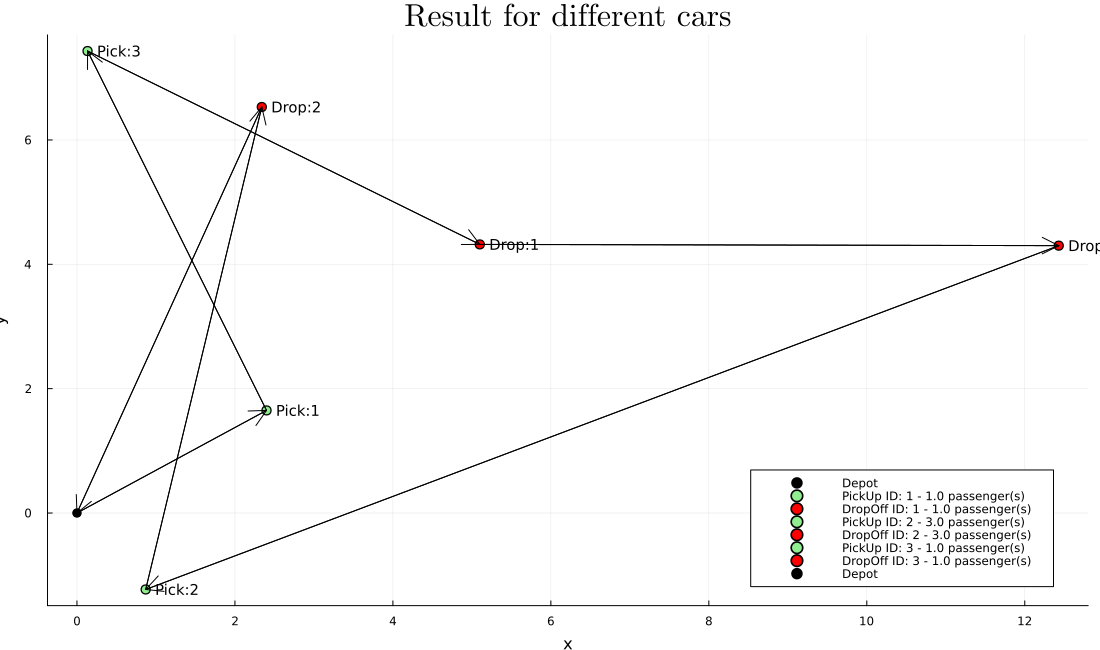

In [32]:
plot_route(data, x_values, w_values, [1100, 650])

# 1 1 --> 1 4 --> 4 7 --> 7 3 --> 3 6 --> 6 8 --> 8 8

# 8 8 --> 8 4 --> 4 7 --> 7 3 --> 3 6 --> 6 1 --> 1 1

In [ ]:
# 1 4 --> 4 7 --> 7 3 --> 3 6 --> 6 1

## How is it possible that we start with node 8 and not with node 1. Probably because the time window of last node is not defined properly.

In [ ]:
# We are missing the constraints on the time windows of the u_depot array!
u_depot_values = value.(u_depot_values)

2×3 Matrix{Float64}:
   0.0    0.0    0.0
 100.0  100.0  100.0

In [ ]:
findall(value.(x)[:, :, 1] .== 1.0)


2-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(8, 8)

In [ ]:
# using PlotlyJS
using Plots
using StatsPlots
pyplot()

function plot_route_car_number(car_number) 

    # plot of scatter plot of the fully_served vector
    Plots.scatter([0], [0], color="black", labels="Depot Begin", size = (1000,750), title="Result for car number: $car_number", format=:png)

    #change the shape for visualization
    scatter!([data[2, 2]], [data[2, 3]],
        titlefont=font(20, "Computer Modern"), 
        color="lightgreen", 
        xlabel="x", ylabel="y",
        labels="Origin: Passenger 1",  
        annotations = (data[2, 2], data[2, 3], Plots.text("PickUp: 1", :left, pointsize=10)),
        format=:png,
        markersize=10,
        legend = :outerright)

    scatter!([data[2+N, 2]], [data[2+N, 3]], 
        color="darkgreen", 
        labels="Destination: Passenger 1", 
        annotations = (data[2+N, 2], data[2+N, 3], Plots.text("DropOff: 1", :left, pointsize=10)),
        markersize=10,
        format=:png)

    scatter!([data[3, 2]], [data[3, 3]], 
        color="lightblue", 
        labels="Origin: Passenger 2", 
        annotations = (data[3, 2], data[3, 3], Plots.text("PickUp: 2", :left, pointsize=10)),
        markersize=10,
        format=:png)

    scatter!([data[3+N, 2]], [data[3+N, 3]], 
        color="darkblue", 
        labels="Destination: Passenger 2", 
        annotations = (data[3+N, 2], data[3+N, 3], Plots.text("DropOff: 2", :left, pointsize=10)),
        markersize=10,
        format=:png)

    scatter!([data[4, 2]], [data[4, 3]], 
        color="red", 
        labels="Origin: Passenger 3", 
        annotations = (data[4, 2], data[4, 3], Plots.text("PickUp: 3", :left, pointsize=10)),
        markersize=10,
        format=:png)

    scatter!([data[4+N, 2]], [data[4+N, 3]],
        color="darkred", 
        labels="Destination: Passenger 3", 
        annotations = (data[4+N, 2], data[4+N, 3], Plots.text("DropOff: 3", :left, pointsize=10)),
        markersize=10,
        format=:png)

    # plot of the route of vehicle 1
    for i in 1:2*N+2
        for j in 1:2*N+2
            if x_values[i, j, car_number] == 1
                print(i, " ", j, "\n")
                plot!([data[i, 2], data[j, 2]], [data[i, 3], data[j, 3]], color="black", labels="$i $j", textposition="bottom left", linewidth=1, arrow=true, format=:png)
            end
        end
    end

    scatter!([0], [0], color="black", labels="Depot End", format=:png)
end

plot_route_car_number (generic function with 1 method)

1 1
8 8


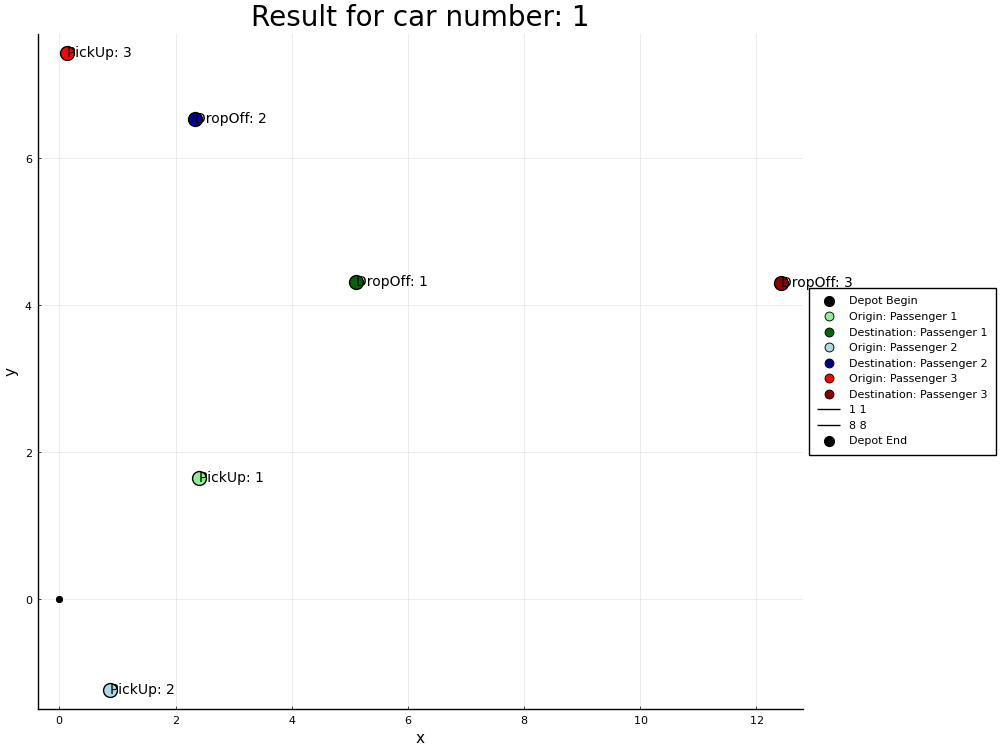

In [ ]:
plot_route_car_number(1)

1 1
8 8


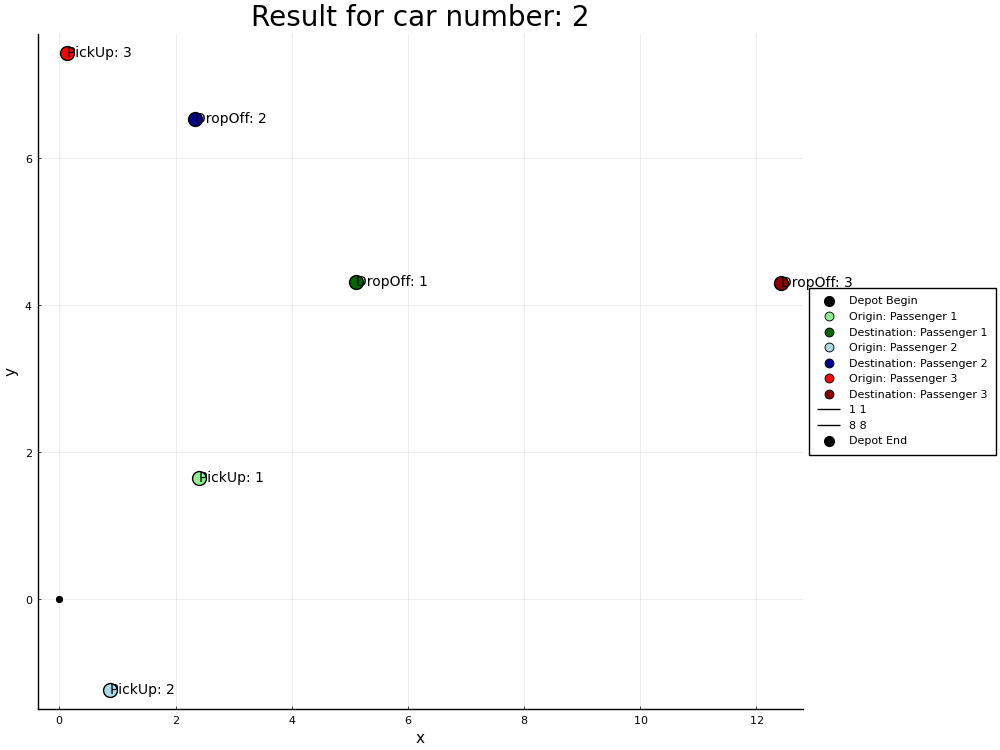

In [ ]:
plot_route_car_number(2)

1 1
2 4
3 6
4 5
5 7
6 1
7 3
8 2
8 8


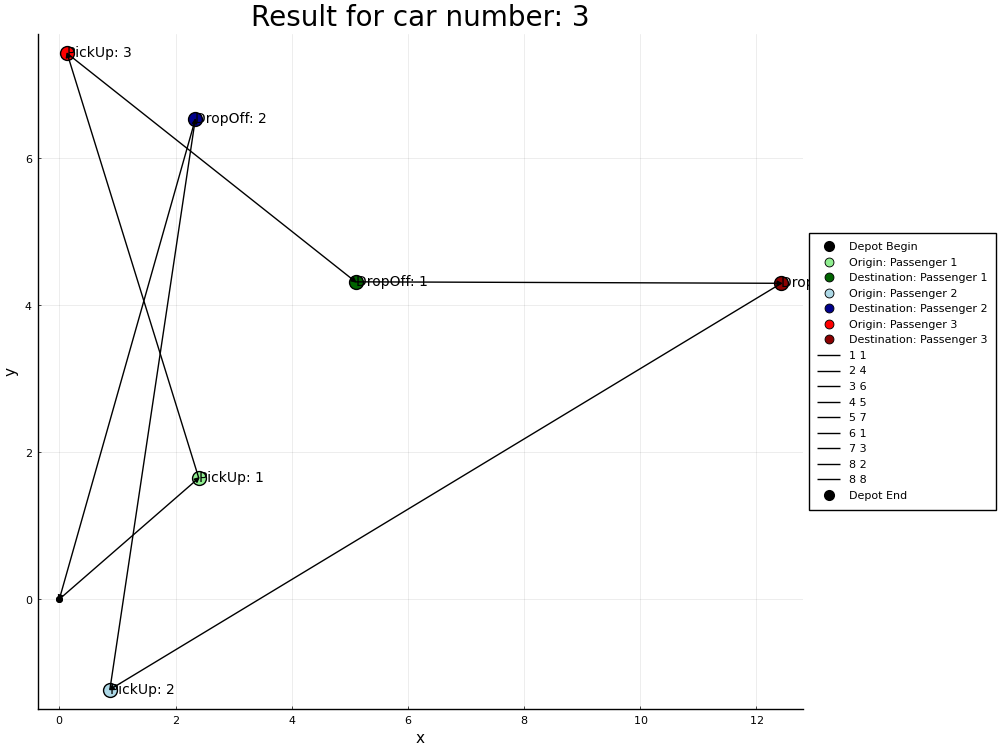

In [ ]:
plot_route_car_number(3)

### Model with more variables

In [ ]:
model2 = Model(Gurobi.Optimizer)

V = [1, 2, 3, 4, 5, 6, 7, 8]   # all vertices
P = [2, 3, 4]             # pick up vertices
D = [5, 6, 7]             # drop off vertices
PUD = [2, 3, 4, 5, 6, 7]     # all pick up and drop off vertices together (all vertices except depot)

T = [100, 100, 100]       # maximum duration of route k
L = 100                  # maximum time of a drive
Q = [3, 3, 3]             # capacity of each car

# Variables
@variable(model2, x[1:2*N+2, 1:2*N+2, 1:K] >= 0, Bin)   # x[i, j, k] = 1 if we go from node i to node j with vehicle k.
@variable(model2, w[1:2*N+2, 1:K] >= 0, Int)            # w[i,k] load of vehicle k when arriving upon leaving vertex i
@variable(model2, r[1:N,1:K] >= 0)                     # r[i,k] travel time of passenger i (Note that passenger i is identified by) the vertex i+1
@variable(model2, u[1:2*N+2, 1:K] >= 0)                 # u[i,k] time as which the vertex i is served by vehicle k


#############  Constraints  #############

# only one car can bring passenger {i, i+N} to its final destination.
@constraint(model2, [i in P], sum(sum(x[i, j, k] for j in V) for k = 1:K) == 1)

# each vehicle starts at the depot
@constraint(model2, [k = 1:K], sum(x[1, j, k] for j in V) == 1)

# each vehicle ends at the depot
@constraint(model2, [k = 1:K], sum(x[i, 2*N+2, k] for i in V) == 1)

# each passenger is picked and droped by the same car
@constraint(model2, [i in P, k = 1:K], sum(x[i, j, k] for j in V) - sum(x[i+N, j, k] for j in V) == 0)

# vehicle k follows the edges sequentially
@constraint(model2, [i in PUD, k = 1:K], sum(x[j, i, k] for j in V) - sum(x[i, j, k] for j in V) == 0)

#### -------- CORRETIONS ######

# PREVIOUS the time served of vertex i
@constraint(model2, [i in V, j in V, k = 1:K], u[j, k] >= (u[i, k] + d[i] + t[i, j]) * x[i, j, k])

# PREVIOUS updating the travel time of passenger i
@constraint(model2, [i in P, k = 1:K], r[i-1, k] == u[N+i, k] - (u[i, k] + d[i]))

# updating the load of the vehicle
@constraint(model2, [i in V, j in V, k = 1:K], w[j, k] >= (w[i, k] + q[j]) * x[i, j, k])

# maximum driving car of vehicle k
@constraint(model2, [k = 1:K], u[2*N+2, k] - u[1, k] <= T[k])

#### -------- CORRETIONS ######3

# respecting travel window of passenger i
@constraint(model2, [i in PUD, k=1:K], e[i] <= u[i, k])
@constraint(model2, [i in PUD, k=1:K], u[i, k] <= l[i])

# respecting travel window of passenger i
@constraint(model2, [i in P, k=1:K], t[i, N+i] <= r[i-1,k])
@constraint(model2, [i in P, k=1:K], r[i-1,k] <= L)

# respecting each car's capacity
@constraint(model2, [i in V, k = 1:K], max(0, q[i]) <= w[i, k])
@constraint(model2, [i in V, k = 1:K], w[i, k] <= min(Q[k], Q[k] + q[i]))

### --- ADDITIONAL CONSTRAINTS -----

# Pick up before drop off
@constraint(model2, [i in P], u[i] <= u[N+i])

# No passengers at the beginning / end
@constraint(model2, [k = 1:K], w[1, k] == 0)
@constraint(model2, [k = 1:K], w[2*N+2, k] == 0)

# objective
# @objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V));

# Objective with a penalty function in the ride time and on the load of each car
@objective(model2, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V) + sum(w) + sum(u));


Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [ ]:
optimize!(model2)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 159 rows, 249 columns and 663 nonzeros
Model fingerprint: 0x2eaed314
Model has 384 quadratic constraints
Variable types: 33 continuous, 216 integer (192 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e-01, 3e+00]
  Objective range  [2e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+03]
Presolve added 6 rows and 0 columns
Presolve removed 0 rows and 78 columns
Presolve time: 0.00s
Presolved: 315 rows, 309 columns, 1134 nonzeros
Presolved model has 84 SOS constraint(s)
Variable types: 117 continuous, 192 integer (168 binary)

Root relaxation: objective 6.715679e+01, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 